# Spectral and temporal modifications Lab

KANG Jiale

*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython
from math import ceil
import soundfile as sf

## Functions

In [2]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return int(P), voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [4]:
x, Fs= sf.read(file_path)

In [5]:
IPython.display.Audio(file_path)

In [6]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

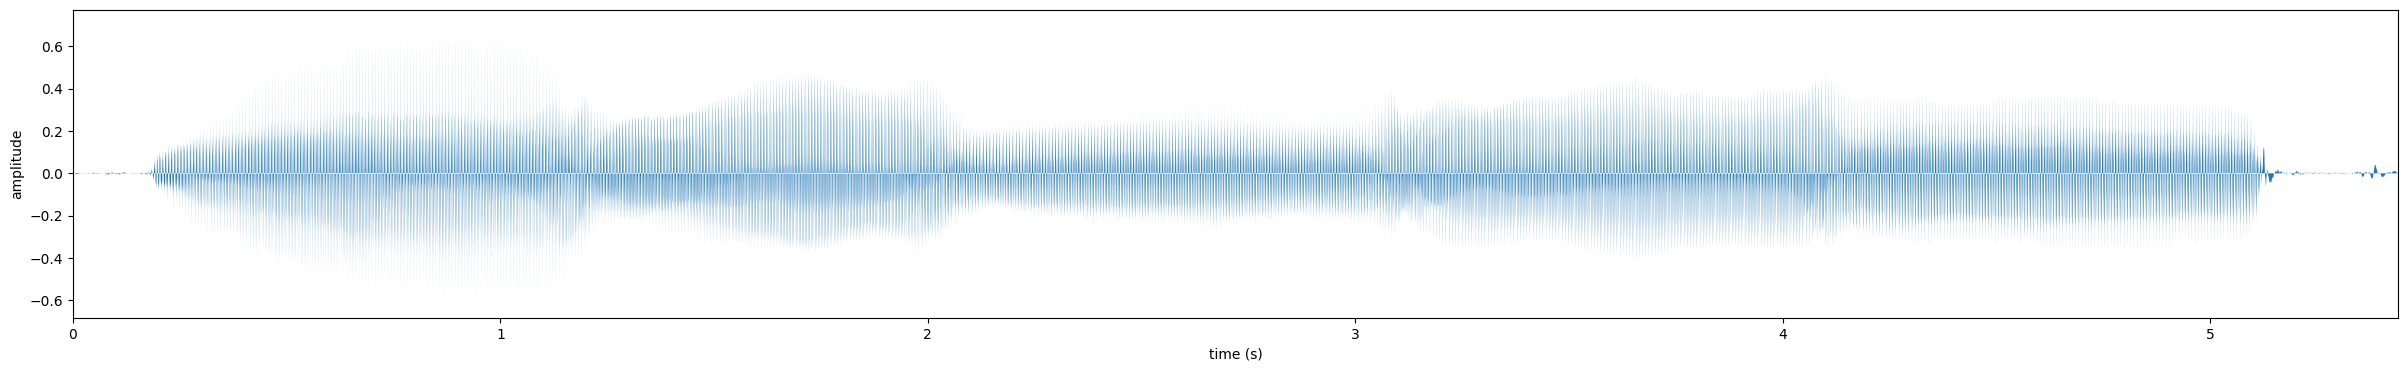

In [7]:
plot_sound(x, times)

In [8]:
sf.write('new_aeiou.wav',x, samplerate=Fs) # to write a new wave file

## 1 Extraction of the analysis marks

Firstly, you will program the following function

<center><code>
function A = AnalysisPitchMarks(s,Fs)
</center></code>

which extracts the analysis marks. The arguments $\mathtt{s}$ and $\mathtt{Fs}$ respectively are the signal to be analyzed and the sampling frequency. The returned matrix $\mathtt{A}$ will contain the times and pitches corresponding to each analysis mark. More precisely, $\mathtt{A}$ will be formed of three rows, such that $\mathtt{A(1,n)} = t_a(n)$ is the time corresponding to the $n^{th}$ analysis mark ($t_a(n) \in \mathbb{N}$ is expressed in number of samples), $\mathtt{A(2,n)} = \mathrm{voiced}(n)$ is a Boolean which indicates whether the signal is voiced or unvoiced in the neighborhood of this mark, and $\mathtt{A(3,n)} = P_a(n) \in \mathbb{N}$ describes the pitch corresponding to the same mark (i.e. the period expressed in number of samples) in the voiced case, or equals $10ms × \mathtt{Fs}$ in the unvoiced case.

To do so, you will need a pitch estimator. In order to spare time, you can use function $\mathtt{period.m}$, whose Matlab code is provided with the example signals, and whose Python code is included in the notebook template $\mathtt{template-TP-HR.ipynb}$. This function requires two arguments: a short term signal $\mathtt{x}$ extracted from $\mathtt{s}$, and the sampling frequency $\mathtt{Fs}$ (the other arguments are optional), and returns a couple $\mathtt{[P, voiced]}$ where $\mathtt{voiced}$ is a Boolean which indicates whether $\mathtt{x}$ is voiced or non, and $\mathtt{P} \in \mathbb{N}$ is the period expressed in number of samples in the voiced case, or equals $10ms × \mathtt{Fs}$ in the unvoiced case.

Let us now detail how to determine the analysis marks. For the sake of simplicity, we will not try to align the mark $t_a(n)$ on the beginning of a glottal pulse. To compute $P_a(n)$ and $t_a(n)$, we proceed by recursion on $n \geq 1$:

- extraction of a sequence $\mathtt{x}$ that starts at time $t_a(n−1)$, and whose duration is equal to $2.5 P_a(n−1)$;
- computation of $P_a(n)$ and $\mathrm{voiced(n)}$ by means of function period;
- computation of $t_a(n) = t_a(n − 1) + P_a(n)$.
  
The algorithm will be initialized by setting $t_a(0) = 1$ (in Matlab) or $t_a(0) = 0$ (in Python) and $P_a(0) =
10ms × Fs$.


In [9]:
def  AnalysisPitchMarks(s, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7) :
# @brief extracts the analysis marks
# @param s the signal to be analyzed
# @param Fs sampling frequency
# @return A contains the times and pitches corresponding to each analysis mark
#         A[0,n] = ta(n), A[1,n] = voiced(n), A[2,n] = Pa(n)

    N = len(s)
    if N < 0:
        raise ValueError('The signal must be non-empty')
    
    ta = np.array([0])
    voiced = np.array([0])
    pa = np.array([0.01 * Fs])
    while ta[-1] + 2.5 * pa[-1] < N :
        x = s[int(ta[-1]): int(ta[-1] + 2.5 * pa[-1])]
        P, voiced_ = period(x, Fs, Pmin, Pmax, seuil)
        pa = np.append(pa, P)
        voiced = np.append(voiced, voiced_)
        ta = np.append(ta, ta[-1] + int(pa[-1]))
    
    A = np.array([ta, voiced, pa])

    return A

In [10]:
A = AnalysisPitchMarks(x, Fs)

## 2 Synthesis and modification of the temporal and spectral scales

To perform the synthesis of the signal, we must start by defining the synthesis marks. They will be stocked in a matrix $\mathtt{B}$ formed of two rows, such that $\mathtt{B(1,k)} = t_s(k)$ is the time corresponding to the $\mathtt{k}$ th
synthesis mark, and $\mathtt{B(2,k) = n(k)}$ is the index of the analysis mark corresponding to this same synthesis mark. To start, you can perform a synthesis without modification, by setting:
- $\mathtt{B(1,:) = A(1,:)}$;
- $\mathtt{B(2,:) = [1, 2, 3, . . .]}$.

In [11]:
B = np.zeros((2, len(A[0])))
B[0,:] = A[0,:].astype(int)
B[1,:] = np.arange(len(A[0])).astype(int)

### 2.1 Signal synthesis

You will now program the following function

<center><code>
function y = Synthesis(s,Fs,A,B)
</center></code>

which computes the synthesis signal $\mathtt{y}$ from the original signal $\mathtt{s}$, the sampling frequency $\mathtt{Fs}$, the analysis marks stocked in matrix $\mathtt{A}$ and the synthesis marks stocked in matrix $\mathtt{B}$. The synthesis is very simply performed by recursion on $\mathtt{k} \geq 1$ (vector $\mathtt{y}$ being initialized to the zero vector of dimension $t_s(k_{end}) + P_a(n(k_{end}))$):
- extraction of a sequence $\mathtt{x}$ centered at $t_a(n(k))$ and of length $2 P_a(n(k)) + 1$;
- windowing of $\mathtt{x}$ by a Hann window (Matlab function hann or Python function $\mathtt{scipy.signal.hanning}$);
- overlap-add of the sequence $\mathtt{x}$ windowed on $y(t_s(k) − Pa(n(k)) : t_s(k) + P_a(n(k)))$.

In [12]:
from scipy.signal.windows import hann

def Synthesis(s,A,B):
# @brief computes the synthesis signal y 
# @param s the original signal
# @param A the analysis marks stocked in matrix A 
# @param B the synthesis marks stocked in matrix B
# @return y the synthesis signal

    ta = A[0,:]
    Pa = A[2,:]
    ts = B[0,:]
    N = B[1,:]

    y = np.zeros(int(ts[-1])+int(Pa[-1]))
    
    k = 0 

    while k < B.shape[1]:
        n_k = int(N[k])
        x = s[int(ta[n_k]-int(Pa[n_k])):int(ta[n_k]+int(Pa[n_k]))]
        ws = hann(len(x))
        y[int(ts[k]-int(Pa[n_k])):int(ts[k]+int(Pa[n_k]))] += x*ws

        k = k+1
        
    return y

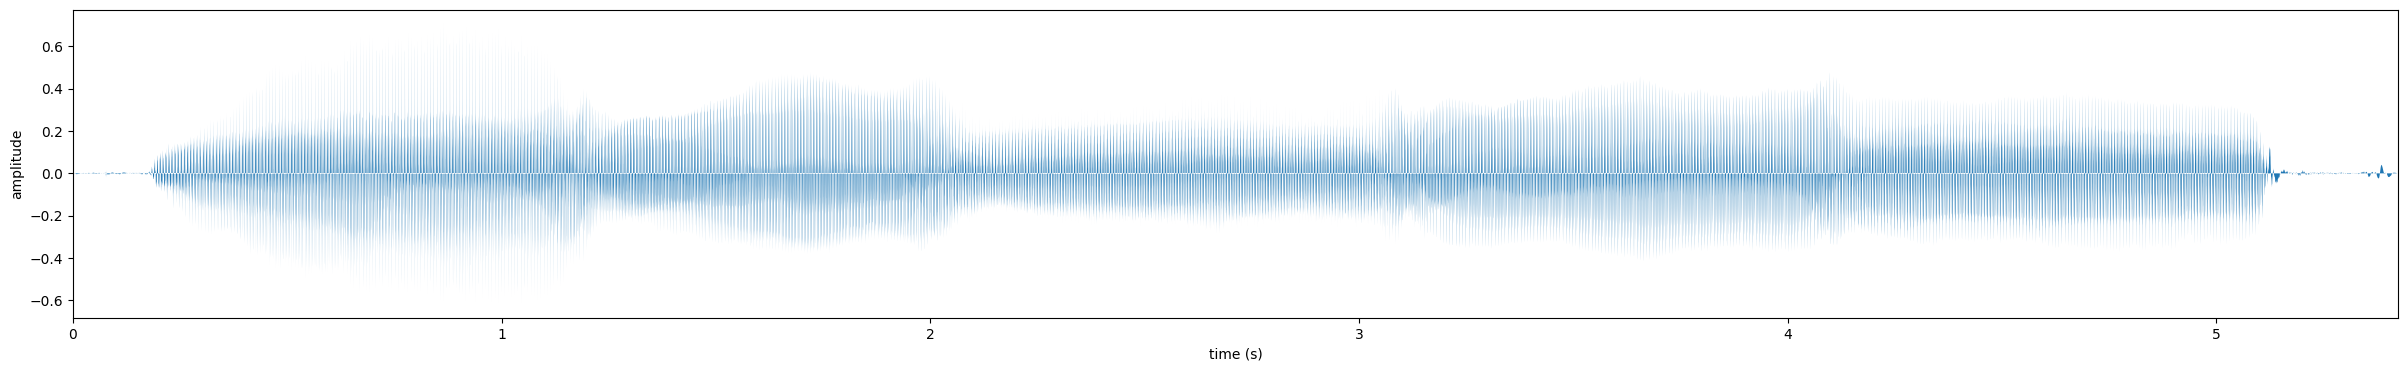

In [13]:
y = Synthesis(x, A, B)

# plot the synthesis signal
plot_sound(y, np.arange(len(y)) * timestep)

### 2.2 Modification of the temporal scale

We now want to determine the synthesis marks that will modify the temporal scale by a factor $\alpha$, i.e. to determine a matrix $\mathtt{B}$ such that the duration of the signal synthesized by function Synthesis is equal to that of the original signal $\mathtt{s}$ multiplied by $\alpha$. This operation will be performed by function

<center><code>
function B = ChangeTimeScale(alpha,A,Fs)
</center></code>

which computes matrix $\mathtt{B}$ from the factor $\alpha$, the analysis marks stocked in $\mathtt{A}$, and the sampling frequency $\mathtt{Fs}$. You can proceed by recursion on $\mathtt{k} \geq 1$, by using a non-integer index $\mathtt{n(k)}$:
- $t_s(k) = t_s(k − 1) + P_a(\lfloor n(k) \rfloor)$;
- $n(k + 1) = n(k) + \frac{1}{\alpha}$.

The algorithm will be initialized by setting $t_s(0) = 1$ and $n(1) = 1$. You will take care of only stocking integer values in matrix $\mathtt{B}$.

In [14]:
def ChangeTimeScale(alpha, A) :
# @brief changes the time scale of the analysis marks
# @param alpha the time scale factor
# @param A the analysis marks
# @return B the synthesis marks

    pa = A[2,:]
    ts = np.array([1])
    N = np.array([0,1])
    l = N[-1]
    while l < len(pa):
        ts = np.append(ts, ts[-1] + pa[l])
        N = np.append(N, N[-1] + 1/alpha)
        l = int(N[-1])

    B = np.array([ts, N[:-1]]).astype(int)
    return B

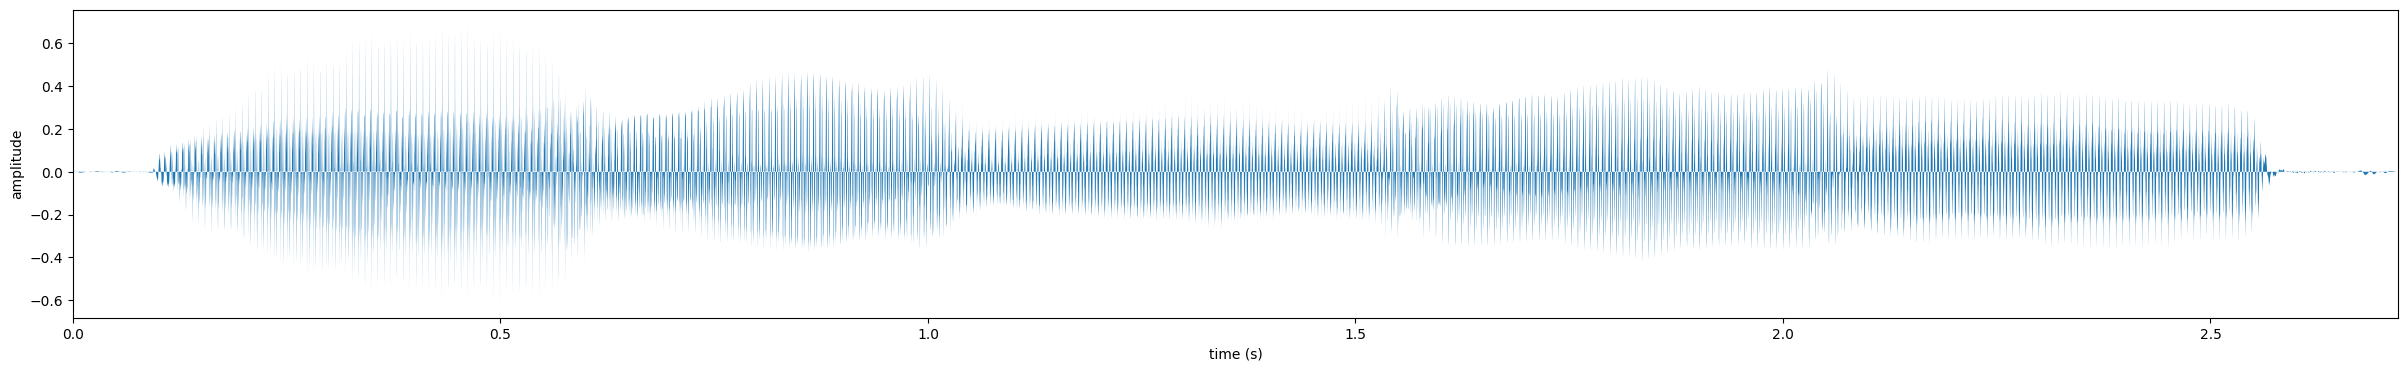

In [15]:
B = ChangeTimeScale(0.5, A)
y = Synthesis(x, A, B)
plot_sound(y, np.arange(len(y)) * timestep)


In [16]:
sf.write('y_change_time.wav', y, Fs)
IPython.display.Audio('y_change_time.wav')

### 2.3 Modification of the spectral scale

You will now perform the dual operation of the previous one: determine the synthesis marks that will modify the spectral scale by a factor $\beta$, i.e. determine a matrix $\mathtt{B}$ such that the fundamental frequency of the signal synthesized by function $\mathtt{Synthesis}$ is equal to that of the original signal $\mathtt{s}$ multiplied by $\beta$. This operation will be performed by function

<center><code>
function B = ChangePitchScale(beta,A,Fs)
</center></code>

which computes matrix $\mathtt{B}$ from the factor $\beta$, the analysis marks stocked in $\mathtt{A}$, and the sampling frequency $\mathtt{Fs}$. As in the previous case, you can proceed by recursion on $\mathtt{k} \geq 1$, by using a non-integer index $n(k)$ and non-integer synthesis times $t_s(k)$, and by making the difference between the voiced and unvoiced cases:
- if the analysis mark of index $\lfloor n(k)\rfloor$ is voiced, $\mathrm{scale(k)} = \frac{1}{\beta}$, otherwise $\mathrm{scale(k)} = 1$;
- $t_s(k) = t_s(k − 1) + \mathrm{scale(k)} × P_a(\lfloor n(k)\rfloor)$;
- $n(k + 1) = n(k) + \mathrm{scale(k)}$.

Again, you will take care of only stocking integer values in matrix $\mathtt{B}$.



In [17]:
def ChangePitchScale(beta, A):
# @brief changes the pitch scale of the analysis marks
# @param beta the pitch scale factor
# @param A the analysis marks
# @return B the synthesis marks

    voiced = A[1,:]
    pa = A[2,:]
    ts = np.array([1])
    N = np.array([0,1])
    l = N[-1]
    scale = np.ones(len(A[1,:]))
    scale[voiced == 1] = 1/beta
    while l < len(pa):
        ts = np.append(ts, ts[-1] + scale[int(l)] * pa[int(l)])
        N = np.append(N, N[-1] + scale[int(l)])
        l = int(N[-1])
    B = np.array([ts, N[:-1]]).astype(int)
    
    return B

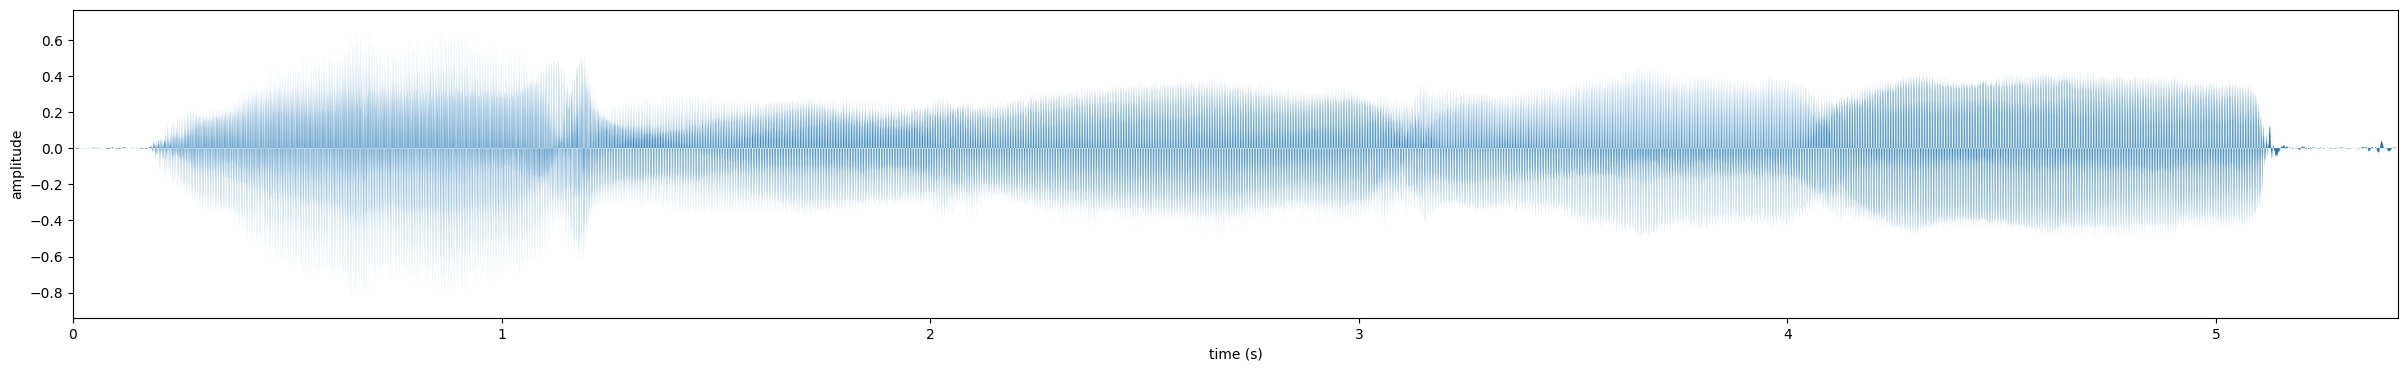

In [18]:
B = ChangePitchScale(2, A)
y = Synthesis(x, A, B)
plot_sound(y, np.arange(len(y)) * timestep)

In [19]:
sf.write('y_change_pitch.wav', y, Fs)
IPython.display.Audio('y_change_pitch.wav')

### 2.4 Joint modification of the temporal and spectral scales

To finish, you will program a function that jointly modifies the two scales:

<center><code>
function B = ChangeBothScales(alpha,beta,A,Fs)
</center></code>

where the arguments are defined as previously. The content of this function will be almost identical to that of $\mathtt{ChangePitchScale}$; you will just need to modify it properly.

In [20]:
def ChangeBothScales(alpha,beta,A) :
# @brief changes both the time and pitch scales of the analysis marks
# @param alpha the time scale factor
# @param beta the pitch scale factor
# @param A the analysis marks
# @return B the synthesis marks

    voiced = A[1,:]
    pa = A[2,:]
    ts = np.array([1])
    N = np.array([0,1])
    l = N[-1]
    scale = np.ones(len(A[1,:]))
    scale[voiced == 1] = 1/beta
    while l < len(pa):
        ts = np.append(ts, ts[-1] + scale[int(l)] * pa[int(l)])
        N = np.append(N, N[-1] + scale[int(l)]/alpha)
        l = int(N[-1])
    B = np.array([ts, N[:-1]]).astype(int)
    
    return B

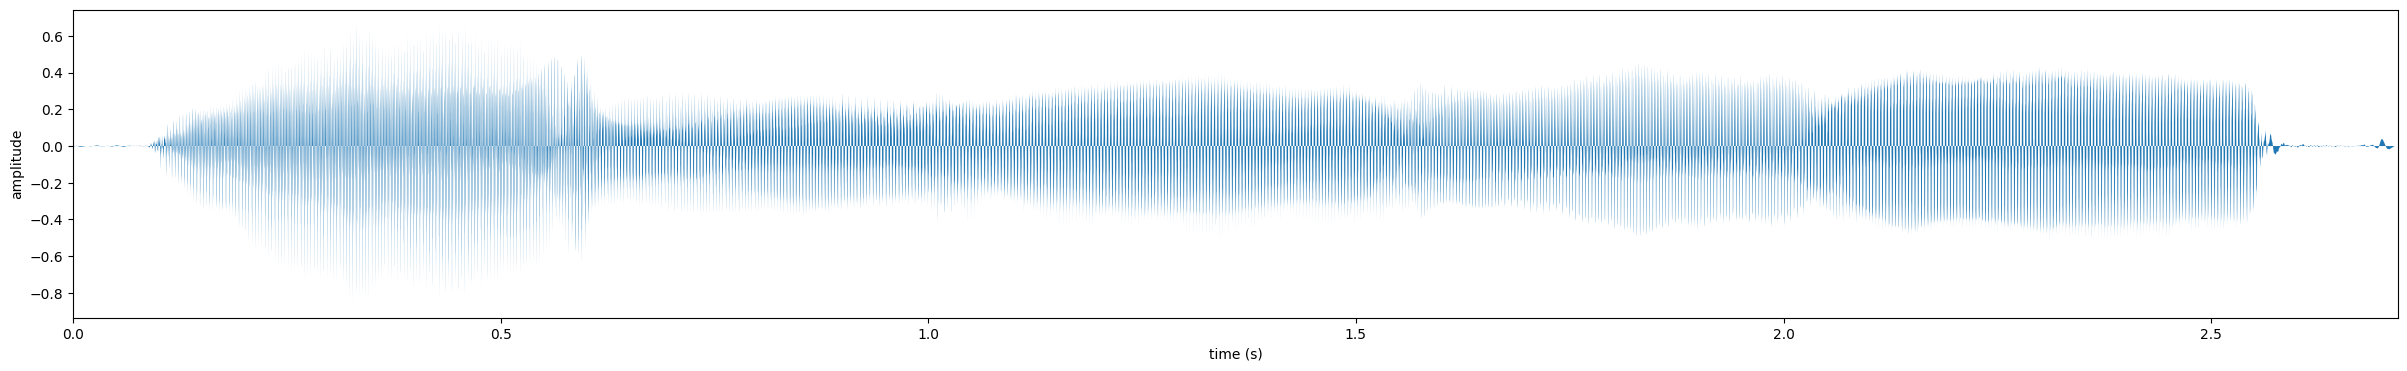

In [22]:
B = ChangeBothScales(0.5, 2, A)
y = Synthesis(x, A, B)
plot_sound(y, np.arange(len(y)) * timestep)

In [23]:
sf.write('y_change_both.wav', y, Fs)
IPython.display.Audio('y_change_both.wav')